In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-data/de_duplicated_data.csv


In [2]:
from pathlib import Path
loan_data_dir = Path('/kaggle/input/loan-data')
output_dir = Path('/kaggle/working')

In [3]:
loan_df = pd.read_csv(loan_data_dir / 'de_duplicated_data.csv')
loan_df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
loan_df.columns

Index(['SK_ID_PREV', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT', 'TOTAL_REPAID_PER_INSTAL', 'SK_ID_CURR',
       'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'CNT_PAYMENT', 'INTEREST_RATE', 'TARGET', 'CODE_GENDER',
       'DAYS_ID_PUBLISH', 'CURR_AMT_CREDIT', 'CURR_AMT_ANNUITY',
       'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'DAYS_EMPLOYED', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE',
       'NAME_EDUCATION_TYPE', 'LIVE_CITY_NOT_WORK_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')

In [5]:
loan_df.shape

(2839754, 39)

## Filter for previous cash loans with instalment histories which were at most 3 years-old.

In [6]:
at_most_3_yr_df = loan_df[np.abs(loan_df.DAYS_INSTALMENT) <= (365 * 3)]

pct_curr_id_preserved = (len(at_most_3_yr_df.SK_ID_CURR.unique()) / len(loan_df.SK_ID_CURR.unique())) * 100
pct_prev_id_preserved = (len(at_most_3_yr_df.SK_ID_PREV.unique()) / len(loan_df.SK_ID_PREV.unique())) * 100
print(f'PCT SK_ID_CURR: {pct_curr_id_preserved}')
print(f'PCT SK_ID_PREV: {pct_prev_id_preserved}')

PCT SK_ID_CURR: 95.80176820232764
PCT SK_ID_PREV: 85.96217391304349


In [7]:
test_df = at_most_3_yr_df[['SK_ID_CURR', 'TARGET']].copy().drop_duplicates()
test_df.groupby('TARGET').count() #There's 9439 Defaulters for now.

,SK_ID_CURR
TARGET,
0,105640
1,9439


## Compute Feature 1:
## Weighted Average Interest for Previous Loans with Instalment Histories which were at most 3 years old.

In [8]:
cols_to_keep = ['SK_ID_CURR', 'SK_ID_PREV', 'AMT_CREDIT', 'INTEREST_RATE']
interest_df = at_most_3_yr_df.copy()[cols_to_keep].drop_duplicates()

In [9]:
interest_df['TOTAL_AMT_CREDIT'] = interest_df \
                                    .groupby('SK_ID_CURR')['AMT_CREDIT'] \
                                    .transform(np.sum)

interest_df['WEIGHT'] = interest_df['AMT_CREDIT'] / interest_df['TOTAL_AMT_CREDIT']
interest_df['INTEREST_RATE_ADJ'] = interest_df['WEIGHT']  * interest_df['INTEREST_RATE']

interest_df['WEIGHTED_AVR_INTEREST_RATE'] = interest_df \
                                                .groupby('SK_ID_CURR')['INTEREST_RATE_ADJ'] \
                                                .transform(np.sum)

interest_feature_df = interest_df[['SK_ID_CURR', 'WEIGHTED_AVR_INTEREST_RATE']] \
                        .copy().drop_duplicates()
interest_feature_df.head()

,SK_ID_CURR,WEIGHTED_AVR_INTEREST_RATE
0,198678,45.090000
12,277601,33.370296
23,198771,40.000000
33,217553,67.426297
48,330786,35.526539


In [10]:
len(interest_feature_df.SK_ID_CURR.unique()) == len(at_most_3_yr_df.SK_ID_CURR.unique()) #sanity check

True

[Text(0.5, 1.0, 'Distribution of Weighted Average Interest Rate')]

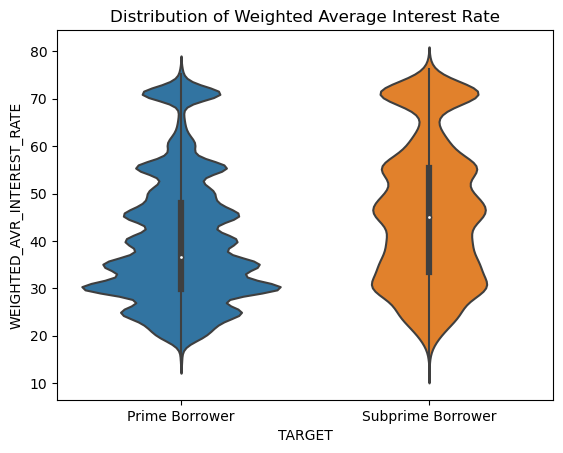

In [11]:
import seaborn as sns

def mapper(target):
    if target == 0:
        return 'Prime Borrower'
    return 'Subprime Borrower'

viz_interest_rate_df = interest_feature_df.merge(test_df, how='inner', on=['SK_ID_CURR'])
viz_interest_rate_df['TARGET'] = viz_interest_rate_df['TARGET'].apply(mapper)

sns.violinplot(
    data=viz_interest_rate_df, x="TARGET", y="WEIGHTED_AVR_INTEREST_RATE")\
    .set(title='Distribution of Weighted Average Interest Rate')

## Compute the following metrics:
2. Sum of Money Owed for instalments which were at most 5 years old.
3. Number of Late Payment streaks for instalments which were at most 5 years old.
4. Number of Consecutive Partial Payment streaks for instalments which were at most 5 years old.
5. Compute loan interest rates.
Note: all these features  are only relevant for curr loan ids in five_yr_instal df

## Compute Feature 2:
## Mean of Days Past Due (DPD) for instalments which were at most 3 years old.

**DAYS_ENTRY_PAYMENT**: The actual which a borrower paid his or her instalment. <br>
For eg: if **DAYS_ENTRY_PAYMENT** is -10, a borrower repaid his or her instalment 10 days prior to current loan application.

**DAYS_INSTALMENT**: The deadline to pay an instalment. <br>
For eg: if **DAYS_INSTALMENT** is -20, a borrower needs to repay his or her instalment 20 days prior to current loan application. <br>

In our example, **DAYS_ENTRY_PAYMENT** occurred after **DAYS_INSTALMENT**, the borrower was late in his or her repayment.

In [38]:
cols_to_keep = ['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 
                'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 
                'AMT_PAYMENT']
three_yr_instal_copy = at_most_3_yr_df \
                        .copy() \
                        .sort_values(by=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])[cols_to_keep]

In [39]:
three_yr_instal_copy['DPD'] = three_yr_instal_copy['DAYS_ENTRY_PAYMENT'] - three_yr_instal_copy['DAYS_INSTALMENT']
three_yr_instal_copy.head()

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DPD
0,198678,1000011,1,-435.0,-438.0,92435.0,92435.0,-3.0
1,198678,1000011,2,-405.0,-411.0,92435.0,92435.0,-6.0
2,198678,1000011,3,-375.0,-377.0,92435.0,92435.0,-2.0
3,198678,1000011,4,-345.0,-346.0,92435.0,92435.0,-1.0
4,198678,1000011,5,-315.0,-314.0,92435.0,92435.0,1.0


In [40]:
dpd_feature_df = three_yr_instal_copy \
                    .groupby(['SK_ID_CURR'])['DPD'].mean().reset_index()

dpd_feature_df.rename(
    {'DPD': 'MEAN_DPD'}, 
    axis=1, inplace=True
)
dpd_feature_df.head()

,SK_ID_CURR,MEAN_DPD
0,100003,-4.428571
1,100006,-23.000000
2,100007,-5.071429
3,100008,-9.250000
4,100011,-6.178571


In [41]:
set(dpd_feature_df.SK_ID_CURR.unique()) == set(at_most_3_yr_df.SK_ID_CURR.unique()) #sanity check

True

In [42]:
def mapper(target):
    if target == 0:
        return 'Prime Borrower'
    return 'Subprime Borrower'

viz_dpd_df = dpd_feature_df.merge(test_df, how='inner', on=['SK_ID_CURR'])
viz_dpd_df['TARGET'] = viz_dpd_df['TARGET'].apply(mapper)

<AxesSubplot:xlabel='TARGET', ylabel='MEAN_DPD'>

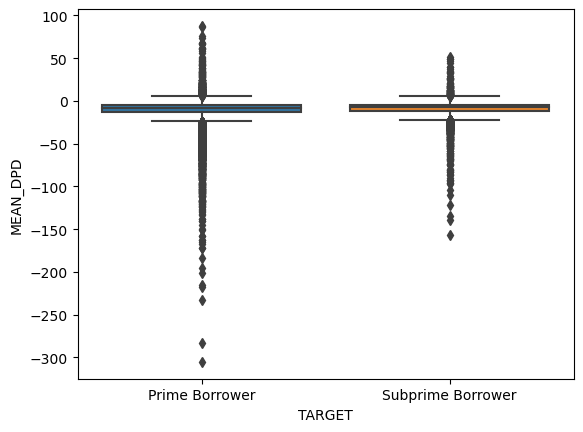

In [43]:
sns.boxplot(data=viz_dpd_df, x="TARGET", y="MEAN_DPD")

<AxesSubplot:xlabel='MEAN_DPD', ylabel='Count'>

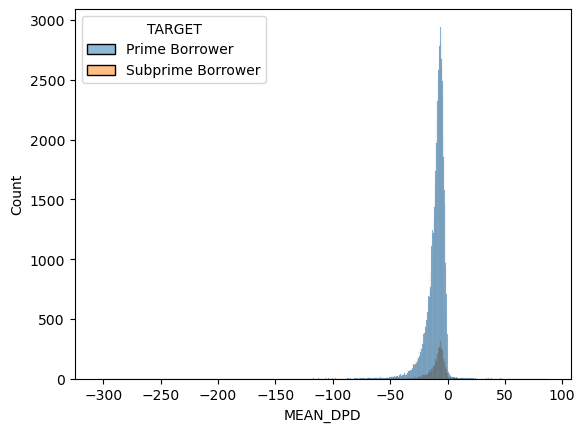

In [44]:
sns.histplot(data=viz_dpd_df, x="MEAN_DPD", hue="TARGET")

## Compute Feature 3: 
## Sum of Money Owed


In [85]:
three_yr_instal_copy.shape

(2247053, 8)

In [102]:
cond = (three_yr_instal_copy.AMT_INSTALMENT > three_yr_instal_copy.AMT_PAYMENT) & (three_yr_instal_copy.DPD > 0)
late_and_partial_payments = three_yr_instal_copy[cond]

test_1_sum_payment = late_and_partial_payments.groupby(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()

In [115]:
instal_1 = late_and_partial_payments.copy()[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT']].drop_duplicates()

test_1 = test_1_sum_payment.merge(instal_1, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

test_1['MONEY_OWED'] = test_1['AMT_INSTALMENT'] - test_1['AMT_PAYMENT'] #find out for late payment, who owes money

test_1[test_1.MONEY_OWED < 0] #

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,AMT_PAYMENT,AMT_INSTALMENT,MONEY_OWED


In [117]:
#double check for dpd < 0, are all instalments repaid.
others = three_yr_instal_copy[~cond]

test_2_sum_payment = others.groupby(['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()

In [121]:
instal_2 = others.copy()[['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER', 'AMT_INSTALMENT']].drop_duplicates()

test_2 = test_2_sum_payment.merge(instal_2, how='inner', on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])

test_2['MONEY_OWED'] = test_2['AMT_INSTALMENT'] - test_2['AMT_PAYMENT'] #find out for timely payment, who owes money, no money, prepays

test_2[test_2.MONEY_OWED == 0] #

,SK_ID_CURR,SK_ID_PREV,NUM_INSTALMENT_NUMBER,AMT_PAYMENT,AMT_INSTALMENT,MONEY_OWED
0,100003,1810518,1,98357.0,98357.0,0.0
1,100003,1810518,2,98357.0,98357.0,0.0
2,100003,1810518,3,98357.0,98357.0,0.0
3,100003,1810518,4,98357.0,98357.0,0.0
4,100003,1810518,5,98357.0,98357.0,0.0
...,...,...,...,...,...,...
2126436,456255,2631384,16,27490.0,27490.0,0.0
2126439,456255,2631384,19,27490.0,27490.0,0.0
2126440,456255,2631384,21,27490.0,27490.0,0.0
2126442,456255,2631384,23,27490.0,27490.0,0.0


In [133]:
combined = pd.concat([test_1, test_2])

money_owed_feature = combined.groupby(['SK_ID_CURR'])['MONEY_OWED'].mean().reset_index()
money_owed_feature

,SK_ID_CURR,MONEY_OWED
0,100003,0.000000
1,100006,0.000000
2,100007,539.976190
3,100008,0.000000
4,100011,4470.714286
...,...,...
115074,456241,0.000000
115075,456244,2026.451613
115076,456245,0.000000
115077,456248,0.000000


In [134]:
def mapper(target):
    if target == 0:
        return 'Prime Borrower'
    return 'Subprime Borrower'

viz_money_owed_df = money_owed_feature .merge(test_df, how='inner', on=['SK_ID_CURR'])
viz_money_owed_df['TARGET'] = viz_money_owed_df['TARGET'].apply(mapper)

[Text(0.5, 1.0, 'Distribution of MONEY_OWED')]

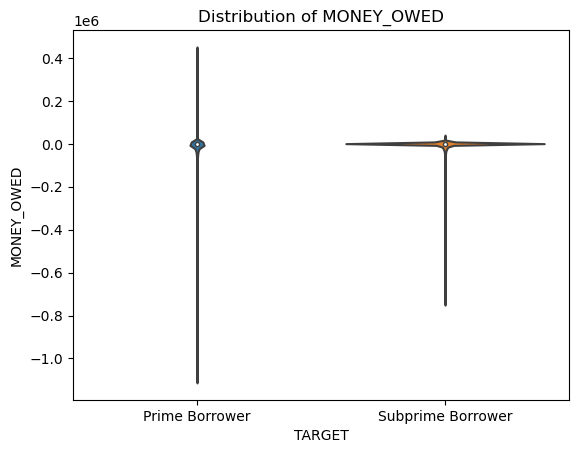

In [135]:
sns.violinplot(
    data=viz_money_owed_df, x="TARGET", y="MONEY_OWED")\
    .set(title='Distribution of MONEY_OWED')

<AxesSubplot:xlabel='TARGET', ylabel='MONEY_OWED'>

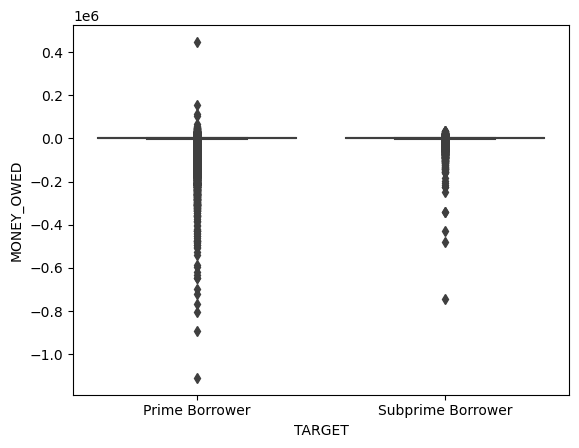

In [136]:
sns.boxplot(data=viz_money_owed_df, x="TARGET", y="MONEY_OWED")

### Compute Frequency of Late Payments
1. A payment can be 1 late payment or a streak of consecutive late payments. See [source](https://joshdevlin.com/blog/calculate-streaks-in-pandas/) and see **compute_total_late_payment** function.
2. Create a new column called is_late.
3. Based on our formula for Days Past Due, is_late if True is Days Past Due is Positive.

In [ ]:
def compute_total_late_payment(instal_info:pd.DataFrame) -> pd.DataFrame:
    """
        Computes number of late payments (can be just 1 late payment or a streak of late payments)
        for just 1 previous loan as denoted by SK_ID_PREV.
        
        Parameters:
        -----------
            instal_info (pd.DataFrame): 
                A dataframe of instalment history for a current borrower for 1 previous loan.
                instal_info must contain the following information:
                    1. SK_ID_CURR.
                    2. SK_ID_PREV.
                    3. IS_LATE.
        
        Returns:
       ----------
       A DataFrame containing 3 pieces of information:
       1. Cumulative count of streaks of late payments for a previous loan.
       2. SK_ID_CURR.
       3. SK_ID_PREV.
       
    """
    instal_info['grouper'] = (instal_info.IS_LATE != instal_info.IS_LATE.shift()).cumsum()
    subset = instal_info[['grouper', 'IS_LATE']]
    
    subset['streaks_count'] = subset.groupby('grouper').cumsum()
    subset['start_of_streak'] = (subset['streaks_count'] == 1) | (subset['streaks_count'] == 0)
    subset['end_of_streak'] = (subset['streaks_count'].shift(-1) == 1) | (subset['streaks_count'].shift(-1) == 0)| (subset['streaks_count'].shift(-1).isnull())
    
    total_late_payments = subset[subset['end_of_streak']]['streaks_count'].sum()
    
    sk_id_curr = instal_info['SK_ID_CURR'].unique()[0]
    sk_id_prev = instal_info['SK_ID_PREV'].unique()[0]
    
    new_data = {'SK_ID_CURR': [sk_id_curr], 
                'SK_ID_PREV': [sk_id_prev], 
                'total_late_payment': [total_late_payments]}
    
    return pd.DataFrame.from_dict(new_data)

In [ ]:
cols_to_show = ['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_PAST_DUE']
instal_copy = three_yr_instal_1.copy()[cols_to_show]
instal_copy['IS_LATE'] = instal_copy['DAYS_PAST_DUE'] > 0
instal_copy.head()

In [ ]:
"""

total_late_payments = []

count = 0
for sk_id_prev in instal_copy.SK_ID_PREV.unique():
    prev_loan_df = instal_copy[instal_copy.SK_ID_PREV == sk_id_prev]
    late_payment_df = compute_total_late_payment(prev_loan_df[['SK_ID_PREV', 'SK_ID_CURR', 'IS_LATE']])
    total_late_payments.append(late_payment_df)
    count += 1
    if count % 10_000 == 0:
        print(count)

late_payments_df = pd.concat(total_late_payments)
late_payments_df.head()
"""

In [ ]:
late_payments_df.rename({'total_late_payment': 'total_late_payments_freq'}, axis=1, inplace=True)
late_payments_df.to_csv(output_dir / 'late_instal_payments_count.csv', index=False)
late_payments_df.head()

### Compute Frequency of Partial Repayment of Instalments
1. Computation is similar to Frequency of Late Payments.
2. I only considered amount of money owed which exceed 100 dollars.

In [ ]:
def compute_total_partial_payment(instal_info:pd.DataFrame) -> pd.DataFrame:
    """
        Computes number of partial instalment payments (can be just 1 partial payment or a streak of partial payments)
        for just 1 previous loan as denoted by SK_ID_PREV.
        
        Parameters:
        -----------
            instal_info (pd.DataFrame): 
                A dataframe of instalment history for a current borrower for 1 previous loan.
                instal_info must contain the following information:
                    1. SK_ID_CURR.
                    2. SK_ID_PREV.
                    3. IS_PARTIAL_REPAYMENT.
        
        Returns:
       ----------
       A DataFrame containing 3 pieces of information:
       1. Cumulative count of streaks of partial payments for a previous loan.
       2. SK_ID_CURR.
       3. SK_ID_PREV.
       
    """
    instal_info['grouper'] = (instal_info.IS_PARTIAL_REPAYMENT != instal_info.IS_PARTIAL_REPAYMENT.shift()).cumsum()
    subset = instal_info[['grouper', 'IS_PARTIAL_REPAYMENT']]
    
    subset['streaks_count'] = subset.groupby('grouper').cumsum()
    subset['start_of_streak'] = (subset['streaks_count'] == 1) | (subset['streaks_count'] == 0)
    subset['end_of_streak'] = (subset['streaks_count'].shift(-1) == 1) | (subset['streaks_count'].shift(-1) == 0)| (subset['streaks_count'].shift(-1).isnull())
    
    total_late_payments = subset[subset['end_of_streak']]['streaks_count'].sum()
    
    sk_id_curr = instal_info['SK_ID_CURR'].unique()[0]
    sk_id_prev = instal_info['SK_ID_PREV'].unique()[0]
    
    new_data = {'SK_ID_CURR': [sk_id_curr], 
                'SK_ID_PREV': [sk_id_prev], 
                'total_partial_payment': [total_late_payments]}
    
    return pd.DataFrame.from_dict(new_data)

In [ ]:
cols_to_keep = ['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_NUMBER', 'MONEY_OWED']
partial_repay = instal_and_prev_apps.copy()[cols_to_keep]
partial_repay['IS_PARTIAL_REPAYMENT'] = partial_repay.MONEY_OWED > 100

In [ ]:
total_partial_payments = []

count = 0
for sk_id_prev in partial_repay.SK_ID_PREV.unique():
    repay_df = partial_repay[partial_repay.SK_ID_PREV == sk_id_prev]
    partial_payment_df = compute_total_partial_payment(repay_df[['SK_ID_PREV', 'SK_ID_CURR', 'IS_PARTIAL_REPAYMENT']])
    total_partial_payments.append(partial_payment_df)
    count += 1
    if count % 10_000 == 0:
        print(count)

partial_payments_df = pd.concat(total_partial_payments)
partial_payments_df.head()

In [ ]:
partial_payments_df.to_csv(output_dir/'partial_payments_count.csv', index=False)